In [810]:
import tensorflow.keras as keras
import numpy as np
import matplotlib
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import to_agraph
import pygraphviz
import graphviz
import networkx as nx
plt.rcParams['figure.figsize'] = [15, 5]
# from RWNN import RWNNmodel

In [835]:
from tensorflow.python.eager import backprop
import tensorflow as tf
from tensorflow.keras.constraints import Constraint
from tensorflow.python.eager import context
from tensorflow.python.framework import constant_op
from tensorflow.python.framework import dtypes
from tensorflow.python.framework import ops
from tensorflow.python.framework import tensor_shape
from tensorflow.python.keras import activations
from tensorflow.python.keras import backend as K
from tensorflow.python.keras import constraints
from tensorflow.python.keras import initializers
from tensorflow.python.keras import regularizers
from tensorflow.python.keras.engine.base_layer import Layer
from tensorflow.python.keras.engine.input_spec import InputSpec
from tensorflow.python.keras.utils import conv_utils
from tensorflow.python.keras.utils import generic_utils
from tensorflow.python.keras.utils import tf_utils
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import gen_math_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import nn
from tensorflow.python.ops import sparse_ops
from tensorflow.python.ops import standard_ops
from tensorflow.python.ops import variable_scope
from tensorflow.python.platform import tf_logging
from tensorflow.python.training.tracking import base as trackable
from tensorflow.python.util import nest
from tensorflow.python.util import tf_inspect
from tensorflow.python.util.tf_export import keras_export

class removeSynapses (Constraint):
    def __init__(self, units):
        msk=1-np.tri(units,units) #upperdiagonal mask
        self.mask=tf.Variable(msk,dtype=tf.float32)
    def __call__(self, w):
        return tf.multiply(self.mask,w)


class RWNN(Layer):
  def __init__(self,
               units,
               outunits,
               activation=None,
               kernel_initializer='glorot_uniform',
               iters=10,
               kernel_regularizer=None,
               activity_regularizer=None,
               kernel_constraint=None,
               **kwargs):
    if 'input_shape' not in kwargs and 'input_dim' in kwargs:
      kwargs['input_shape'] = (kwargs.pop('input_dim'),)

    super(RWNN, self).__init__(
        activity_regularizer=regularizers.get(activity_regularizer), **kwargs)

    self.units = int(units) if not isinstance(units, int) else units
    self.outunits=outunits
    self.iters=iters           
    self.activation = activations.get(activation)
    self.use_bias = False
    self.kernel_initializer = initializers.get(kernel_initializer)
    self.kernel_regularizer = regularizers.get(kernel_regularizer)
    self.kernel_constraint = constraints.get(kernel_constraint)
    
    self.supports_masking = True
    self.input_spec = InputSpec(min_ndim=2)

  def build(self,input_shape):
    dtype = dtypes.as_dtype(self.dtype or K.floatx())
    self.inunits=input_shape[-1]
    self.kernel = self.add_weight(
        'kernel',
        shape=[self.units, self.units],
        initializer=self.kernel_initializer,
        regularizer=self.kernel_regularizer,
        constraint=self.kernel_constraint,
        dtype=self.dtype,
        trainable=True)
#     self.kernel=self.kernel_constraint.__call__(self.kernel)
    self.built = True

  def call(self, inputs,verbose=False):
#     self.kernel=tf.multiply(self.mask,self.kernel)
    if verbose:
        outhistory=[]
    inputs = math_ops.cast(inputs, self._compute_dtype)
    rank = len(inputs.shape)
    if inputs.shape[0] != None:
        z =tf.zeros((inputs.shape[0],self.units-self.inunits), dtype=tf.dtypes.float32, name=None)
    else:
        z =tf.zeros((1,self.units-self.inunits), dtype=tf.dtypes.float32, name=None)
    outputs = tf.concat([inputs, z], 1)
    for j in range(self.iters):
        outputs = gen_math_ops.mat_mul(outputs, self.kernel)
        if self.activation is not None:
            outputs=self.activation(outputs)
        aux= tf.gather(outputs, [self.inunits + i for i in range(self.units-self.inunits)], axis=1)
        outputs=tf.concat([inputs, aux], 1)
        if verbose:
            outhistory.append(np.array(outputs))
#             print (outputs)
#         print (tf.gather(outputs, [self.units-self.outunits + i for i in range(self.outunits)], axis=1))
    if verbose:
        return outhistory
    return tf.gather(outputs, [self.units-self.outunits + i for i in range(self.outunits)], axis=1)
    

  def compute_output_shape(self, input_shape):
    input_shape = tensor_shape.TensorShape(input_shape)
    input_shape = input_shape.with_rank_at_least(2)
    if tensor_shape.dimension_value(input_shape[-1]) is None:
      raise ValueError(
          'The innermost dimension of input_shape must be defined, but saw: %s'
          % input_shape)
    return input_shape[:-1].concatenate(self.outunits)
#     return self.outputs
  def plot_tree(self):
        G = nx.DiGraph(directed=True)
        idd=0
        #Nodes
        for i in range(self.inunits):
            G.add_node(idd,type='input',style='filled',fillcolor='red')
            idd+=1
        for i in range(self.units-self.outunits-self.inunits):
            G.add_node(idd,type='hidden')
            idd+=1
        for i in range(self.outunits):
            G.add_node(idd,type='output',style='filled',fillcolor='blue')
            idd+=1
        #Connections
        for i in range(self.units):
            for j in range(self.units):
                weight=self.kernel[i,j]
                if weight != 0:
                    G.add_edge(i,j)
                    G[i][j]['penwidth']=abs(weight)
                    if weight >0:
                        G[i][j]['color']='green'
                    else:
                        G[i][j]['color']='red'

        #plot
        A = to_agraph(G)
        A.layout('dot')
        graphviz.Source(A).view()


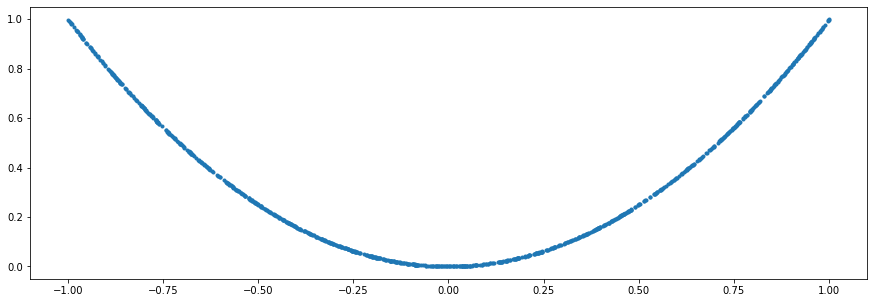

In [825]:
#1D
#simple 1d input -> 1d output training set (easy visualization)
seed=0
rng=np.random.RandomState(seed)
x=2*rng.rand(1000,1)-1
y=(x)**2
plt.plot(x,y,'.',)

In [826]:
init=keras.initializers.RandomUniform(minval=-1, maxval=1, seed=42)
a=RWNN(5,1, activation=None,kernel_initializer=init, kernel_constraint=removeSynapses(5))
a.build((2,))
print (a.kernel)
i=tf.convert_to_tensor([[1,1],[2,2],[3,3]])
o=a.call(i)
print (o)
print (a.compute_output_shape(i.shape))
a.plot_tree()

<tf.Variable 'kernel:0' shape=(5, 5) dtype=float32, numpy=
array([[-0.4351337 , -0.0031662 ,  0.43091702, -0.9595959 , -0.8428037 ],
       [ 0.25311875,  0.50999665, -0.6535883 , -0.7425747 , -0.89465904],
       [ 0.8850584 , -0.5390961 , -0.04491687, -0.5068898 ,  0.449152  ],
       [ 0.5381317 ,  0.07382178, -0.6625898 ,  0.0056169 , -0.6001148 ],
       [-0.92940617, -0.37443924, -0.05121136,  0.11959887,  0.64707446]],
      dtype=float32)>
tf.Tensor(
[[0.5878352]
 [1.1756704]
 [1.7635059]], shape=(3, 1), dtype=float32)
(3, 1)


In [802]:
init=keras.initializers.RandomUniform(minval=-1, maxval=1, seed=42)
a=RWNN(3,1,activation='sigmoid',kernel_initializer=init,iters=100,rnel_constraint=removeSynapses(5))
a.build((1,))
print(a.kernel)
a.call([[1]])

TypeError: ('Keyword argument not understood:', 'rnel_constraint')

In [ ]:
x=list(range(10))
y=[]
for i in x:
    a.iters=i+1
    y.append(np.array(a.call([[1]]))[0][0])
    
plt.plot(x,y)

In [803]:
a.kernel

<tf.Variable 'kernel:0' shape=(5, 5) dtype=float32, numpy=
array([[-0.4351337 , -0.0031662 ,  0.43091702, -0.9595959 , -0.8428037 ],
       [ 0.25311875,  0.50999665, -0.6535883 , -0.7425747 , -0.89465904],
       [ 0.8850584 , -0.5390961 , -0.04491687, -0.5068898 ,  0.449152  ],
       [ 0.5381317 ,  0.07382178, -0.6625898 ,  0.0056169 , -0.6001148 ],
       [-0.92940617, -0.37443924, -0.05121136,  0.11959887,  0.64707446]],
      dtype=float32)>

Model: "sequential_167"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rwnn_337 (RWNN)              (1, 1)                    625       
_________________________________________________________________
dense_110 (Dense)            (1, 1)                    1         
Total params: 626
Trainable params: 626
Non-trainable params: 0
_________________________________________________________________
Train on 1000 samples
Epoch 1/40
1000/1000 [==============================] - 1s 1ms/sample - loss: 0.1367
Epoch 2/40
1000/1000 [==============================] - 1s 565us/sample - loss: 0.0922
Epoch 3/40
1000/1000 [==============================] - 0s 351us/sample - loss: 0.0919
Epoch 4/40
1000/1000 [==============================] - 1s 1ms/sample - loss: 0.0913
Epoch 5/40
1000/1000 [==============================] - 0s 419us/sample - loss: 0.0910
Epoch 6/40
1000/1000 [==============================] - 0s 391u

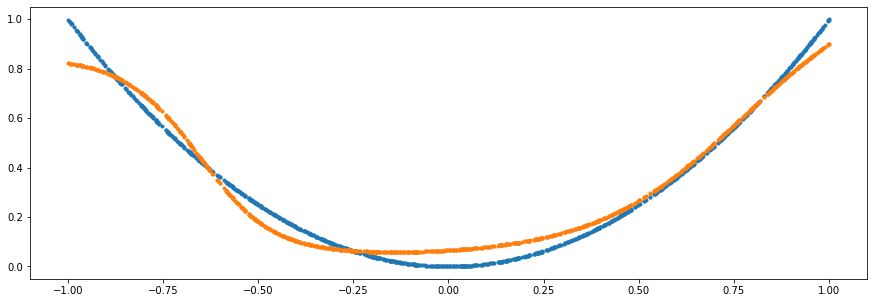

In [845]:
init=keras.initializers.RandomUniform(minval=-1, maxval=1, seed=42)

model = Sequential() 
model.add(RWNN(25,1, activation='sigmoid',input_shape=(1,),kernel_initializer=init,iters=10, kernel_constraint=removeSynapses(25))) 
model.add(Dense(1, activation='linear',use_bias=False,kernel_initializer=init))
          
model.summary()

opt=keras.optimizers.Adagrad(learning_rate=0.1)
model.compile(loss='mean_squared_error',
              optimizer=opt)


history = model.fit(x, y,
                    batch_size=8,
                    epochs=40,
                    verbose=1)
yy=model.predict(x,batch_size=len(x))
plt.plot(x,y,'.')
plt.plot(x,yy,'.')

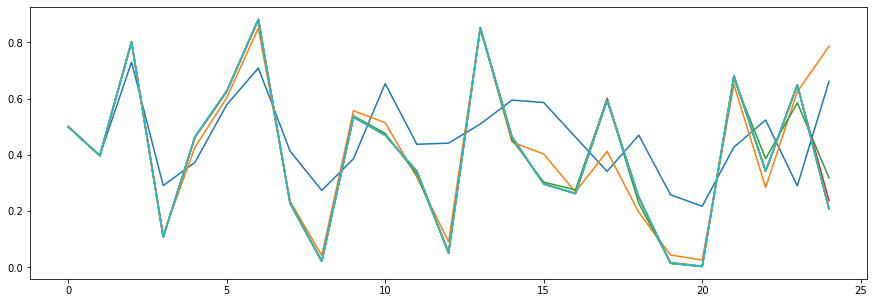

In [846]:
o=model.layers[0].call([[0.5]],verbose=True)
for oi in o:
    plt.plot(oi[0])
    

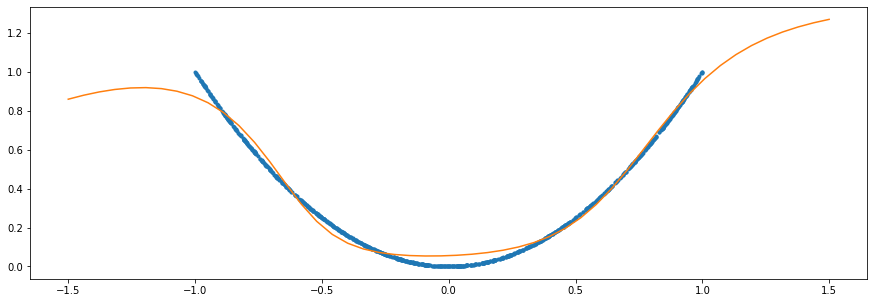

In [758]:
model.layers[0].plot_tree()
xx=np.linspace(-1.5, 1.5, num=50)
yy=model.predict(xx,batch_size=len(xx))
plt.plot(x,y,'.')
plt.plot(xx,yy,'-')

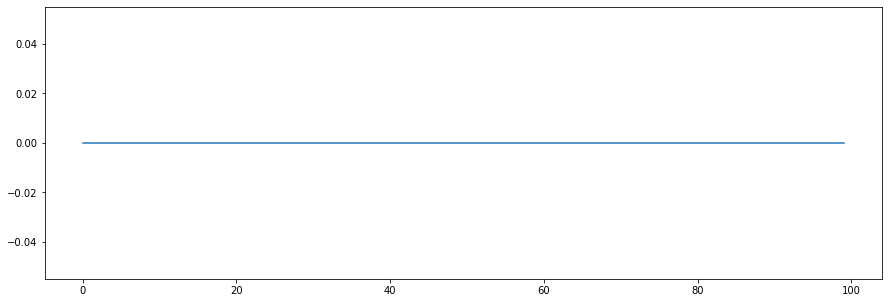

In [752]:
x=list(range(100))
y=[]
for i in x:
    model.layers[0].iters=i+1
    y.append(np.array(model.layers[0].call([[0]]))[0][0])
    
plt.plot(x,y)

In [735]:
# Print Weights 
for layer in model.layers:
    print(layer.get_weights())

[array([[-4.35133696e-01, -3.82817239e-01,  1.00779855e+00,
        -1.90945709e+00, -5.85617304e-01,  3.11477721e-01,
         1.26077855e+00, -7.93397665e-01, -1.33701086e+00,
        -6.11941040e-01,  1.05031955e+00, -5.16675234e-01,
        -1.83850661e-01, -1.64480120e-01,  1.04476273e+00,
        -6.46939427e-02,  9.36235189e-02, -7.52130032e-01,
        -7.98891336e-02, -8.04597855e-01, -1.98219323e+00,
        -5.94056785e-01,  8.10802653e-02, -3.04626852e-01,
         6.44273221e-01],
       [ 1.82733297e-01, -1.44214034e-01,  5.31425357e-01,
        -5.87327778e-01,  3.24634284e-01, -4.60622340e-01,
         9.05655563e-01,  9.15762663e-01,  3.59049469e-01,
        -2.66594052e-01,  3.12989205e-01,  2.47303955e-02,
         9.41657722e-01,  2.30040506e-01, -1.04913771e+00,
         2.66246438e-01,  2.36928731e-01,  9.14195180e-01,
         7.70181358e-01,  7.39425659e-01,  3.82544518e-01,
         6.94042087e-01, -9.23836887e-01,  5.58402658e-01,
        -1.44927919e+00],
   

Model: "sequential_73"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rwnn_178 (RWNN)              (1, 1)                    10000     
Total params: 10,000
Trainable params: 10,000
Non-trainable params: 0
_________________________________________________________________
Train on 1000 samples
Epoch 1/80
1000/1000 [==============================] - 1s 1ms/sample - loss: 1.1277
Epoch 2/80
1000/1000 [==============================] - 0s 382us/sample - loss: 1.1817
Epoch 3/80
1000/1000 [==============================] - 0s 383us/sample - loss: 1.1817
Epoch 4/80
1000/1000 [==============================] - 0s 443us/sample - loss: 1.1817
Epoch 5/80
1000/1000 [==============================] - 0s 398us/sample - loss: 1.1817
Epoch 6/80
1000/1000 [==============================] - 0s 456us/sample - loss: 1.1817
Epoch 7/80
1000/1000 [==============================] - 0s 408us/sample - loss: 1.1817
Epoch 8/80
100

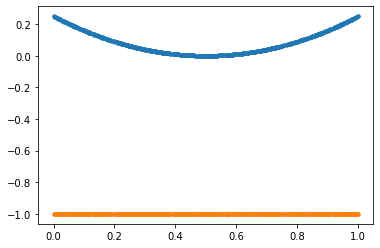

In [414]:
init=keras.initializers.RandomUniform(minval=-1, maxval=1, seed=42)

model = Sequential() 
model.add(RWNN(100,1, activation='tanh',input_shape=(1,),kernel_initializer=init,iters=10, kernel_constraint=removeSynapses(100))) 
          
model.summary()

opt=keras.optimizers.Adagrad(learning_rate=1)
model.compile(loss='mean_squared_error',
              optimizer=opt)


history = model.fit(x, y,
                    batch_size=10,
                    epochs=80,
                    verbose=1)
yy=model.predict(x,batch_size=len(x))
plt.plot(x,y,'.')
plt.plot(x,yy,'.')

In [363]:
msk=np.ones([10,10])
msk *= 1 - np.tri(*msk.shape)
msk

array([[0., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [360]:
msk=np.ones([10,10])
for i in range(10):
    for j in range(10):
        if i>=j:
            msk[i,j]=0
msk

array([[0., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [368]:
1-np.tri(10,10)

array([[0., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [402]:
from tensorflow.python.ops import gen_math_ops
gen_math_ops.mat_mul([[1,10,100]], 1-np.tri(3,3))

<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[ 0,  1, 11]], dtype=int32)>

In [406]:
np.dot([1,10,100], np.ones([3,3]))

array([111., 111., 111.])

In [788]:
def sig(x):
    return 1 / (1 + np.exp(-x))
#     return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x)) 

In [789]:
sig(1)

0.7310585786300049

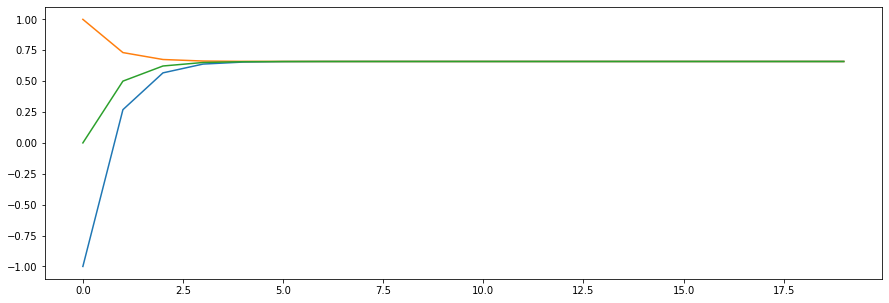

In [807]:
x = list(range(20))
y=[-1]
y2=[1]
y3=[0]
for i in x:
    y.append(sig(y[-1]))
    y2.append(sig(y2[-1]))
    y3.append(sig(y3[-1]))

plt.plot(x,y[:len(x)])
plt.plot(x,y2[:len(x)])
plt.plot(x,y3[:len(x)])

In [808]:
y

[-1,
 0.2689414213699951,
 0.5668330070205946,
 0.6380320873724359,
 0.6543084758952321,
 0.6579807100202137,
 0.6588066371986613,
 0.6589922651251212,
 0.6590339784724807,
 0.6590433517412365,
 0.6590454579604421,
 0.659045931237306,
 0.6590460375846879,
 0.6590460614814077,
 0.6590460668511046,
 0.6590460680576988,
 0.6590460683288258,
 0.6590460683897492,
 0.6590460684034389,
 0.6590460684065151,
 0.6590460684072064]